In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [2]:
from artifacts import data, hostnames, casenames, testnames
items = pd.DataFrame(data)

x_lim = 30
bins = 30

items.head(1)

,_id,case-name,frequency,hostname,intel,l1d,l1i,l2,l3,node_id,nproc,task-size,test-name,time-max,time-min,time-sum
0,57efc0d2087519172d8be2ff,18,3158.74,8,False,32768,32768,6291456,0,57efc0cf087519172d8be2fe,2,942,5,3.337362,3.335431,6.672793


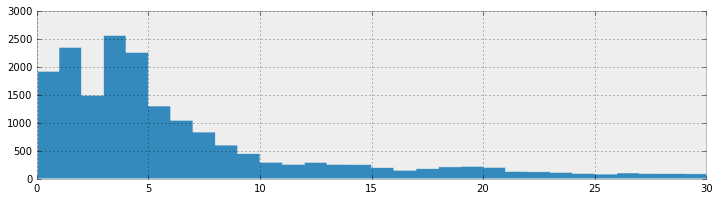

In [3]:
fig = plt.figure(figsize=(12,3))
plt.hist(items['time-sum'].values, range=[0, x_lim], bins=bins, histtype='stepfilled', color=colors[0]);

In [4]:
y_obs = items['time-sum'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 2.61803396034


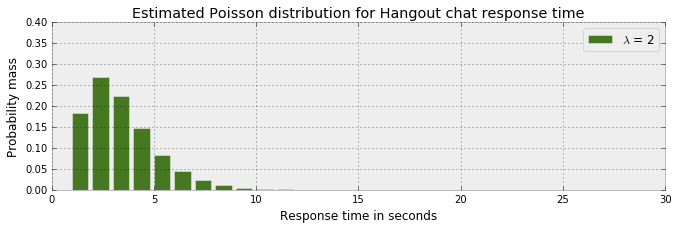

In [5]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, .4)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

In [6]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=items['time-sum'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 6.1 sec

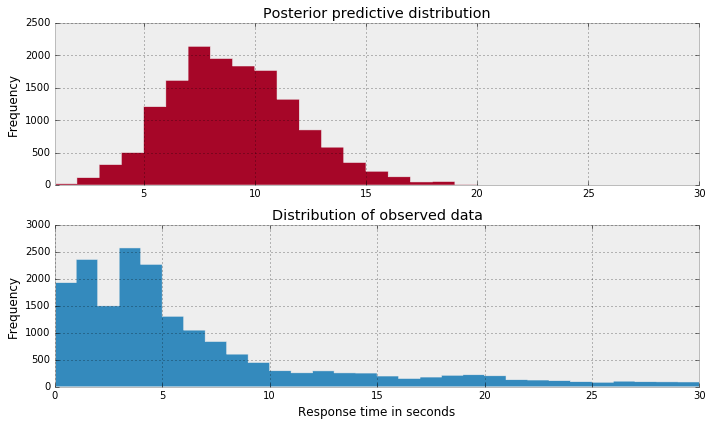

In [7]:
burnin = 5000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()



fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=bins, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(items['time-sum'].values, range=[0, x_lim], bins=bins, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Applied log-transform to alpha and added transformed alpha_log to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 26.0 sec

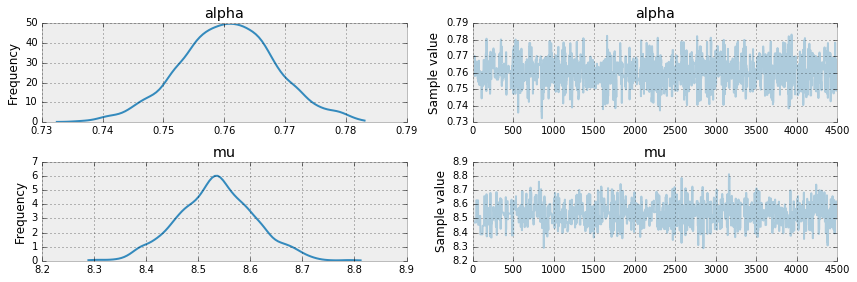

In [8]:
"""fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
x_lim = 70
mu = [15, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[4])

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1])])

plt.tight_layout()
"""

burnin = 500

with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=items['time-sum'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(5000, step, start=start, progressbar=True)

_ = pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

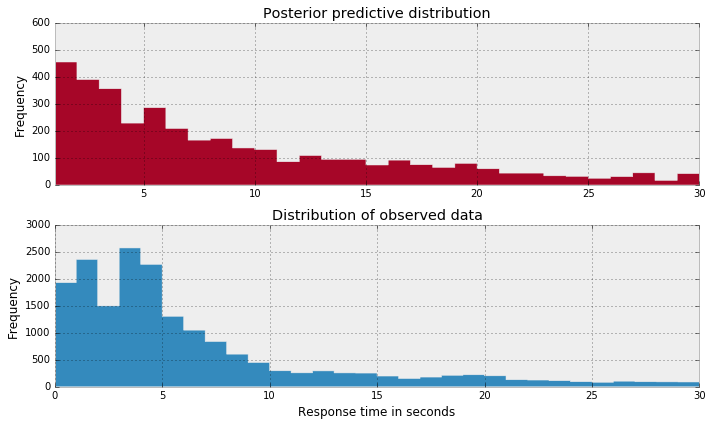

In [9]:
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=bins, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(items['time-sum'].values, range=[0, x_lim], bins=bins, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [11]:
indiv_traces_host = {}
total = len(hostnames)
for c in range(total):
    d = items[items['hostname']==c]['time-sum'].values
    
    print("\n{c:02d} of {total:02d}".format(**locals()))
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=d)
        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)

        start = pm.find_MAP(fmin=opt.fmin_powell)
        step = pm.Metropolis()
        trace = pm.sample(10000, step, start=start, progressbar=True)

        indiv_traces_host[c] = trace

        
indiv_traces_case = {}
total = len(casenames)
for c in range(total):
    d = items[items['case-name']==c]['time-sum'].values
    
    print("\n{c:02d} of {total:02d}\n".format(**locals()))
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=d)
        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)

        start = pm.find_MAP(fmin=opt.fmin_powell)
        step = pm.Metropolis()
        trace = pm.sample(10000, step, start=start, progressbar=True)

        indiv_traces_case[c] = trace




00 of 18
Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 3.6 sec
01 of 18
Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 8.4 sec
02 of 18
Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 5.0 sec
03 of 18
Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 9.5 sec
04 of 18
Applie

In [ ]:
indiv_traces = {}
total = len(hostnames)
start = None
for c in range(total):
    # data = messages[messages['prev_sender']==p]['time_delay_seconds'].values
    d = items[items['hostname']==c]['time-sum'].values
    
    print("{c:02d} of {total:02d}".format(**locals()))
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=d)
        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        #if start is None:
        start = pm.find_MAP(fmin=opt.fmin_powell)
        step = pm.Metropolis()
        #step = pm.NUTS()
        trace = pm.sample(10000, step, start=start, progressbar=True)

        indiv_traces[c] = trace



In [ ]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=bins, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(items['time-sum'].values, range=[0, x_lim], bins=bins, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()